In [27]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
from statistics import mean
import community
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

import random
import copy


from deap import base
from deap import creator
from deap import tools
from math import dist



In [28]:
threshold = 0.7
egoradius = 3

In [29]:
def get_weight(node, node_to_com, com_to_nodes):
    node_com_id = node_to_com[node]
    com = com_to_nodes[node_com_id]
    net = nx.subgraph(g, com)
    count = dict(Counter(list(nx.get_node_attributes(net, 'gender').values())))
    if '0' in count:
        males = count['0']
    else:
        males = 0
    if '1' in count:
        females = count['1']
    else:
        females = 0
        
    if attrs[node] == '1':
        return 1 - females / len(com)
    else:
        return 1 - males / len(com)
    
    print(f'com size: {len(com)}, males: {males}, females: {females}')

In [30]:
g = nx.Graph()
g.name = 'copenhagen'
with open('bt_symmetric.csv') as f:
    for l in f.readlines()[1:]:
        tid, a, b, rssi = l.rstrip().split(',')
        g.add_edge(int(a),int(b), tid=tid)
print('loaded')

attrs = {n: None for n in g.nodes()} # also fix missing data
with open('genders.csv') as f:
    for l in f.readlines()[1:]:
        node, gender = l.rstrip().split(',')
        attrs[int(node)] = gender
    nx.set_node_attributes(g, attrs, name='gender')
print('attributes')

loaded
attributes


In [31]:
to_remove = []
for n in attrs:
    if attrs[n] is None:
        to_remove.append(n)

g.remove_nodes_from(to_remove)

In [32]:
print(nx.info(g))

Name: copenhagen
Type: Graph
Number of nodes: 673
Number of edges: 75124
Average degree: 223.2511


In [33]:
attrs = nx.get_node_attributes(g, 'gender')

In [34]:
#g = nx.convert_node_labels_to_integers(g)
sizes = dict(Counter(list(nx.get_node_attributes(g, 'gender').values())))
sizes['0'] = sizes['0'] / (len(g))
sizes['1'] = sizes['1'] / (len(g))

In [35]:
weights = dict(Counter(list(nx.get_node_attributes(g, 'gender').values())))
weights['0'] = 1 - sizes['0']
weights['1'] = 1 - sizes['1']

In [36]:
def homogeneity(node, attr, center=True):
    
    egonet = nx.ego_graph(g, node, center=center)
    egonet_attrs = list(nx.get_node_attributes(egonet, 'gender').values())
    count = dict(Counter(egonet_attrs))[attr]
    size = len(egonet)
    if size > 2:
        return count/size

#def marginalization(node, attr, center=True):
    
   


In [37]:
margs = []

marg_dict = dict()

print ("ATTR - Weighted Hom - Community Hom")
for node in list(g.nodes()):
    attr = attrs[node]
    
    # COMPUTE MARGINALIZATION
    marg = 0
    egonet = nx.ego_graph(g, node, center=True)
    egonet_attrs = list(nx.get_node_attributes(egonet, 'gender').values())
    count = dict(Counter(egonet_attrs))[attr]
    size = len(egonet)
    if size > 2:
        marg = ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2
        margs.append(marg)  
        if abs(marg) > threshold:
            marg_dict[node] = marg        
        else:
            marg_dict[node] = 0
    else:
        marg_dict[node] = 0

ATTR - Weighted Hom - Community Hom


In [38]:
disc_nodes = [k for k,v in marg_dict.items() if abs(v) > threshold]
disc = len(disc_nodes)

plausible = nx.Graph() # stores plausible links
for node in disc_nodes:
    egonet = nx.ego_graph(g, node, center=True)
    egonet2 = nx.ego_graph(g, node, center=True, radius=egoradius)
    egonet2.remove_nodes_from(egonet)
    for n in egonet2.nodes():
        if node != n and n in disc_nodes:
            if marg_dict[node] > 0:
                if attrs[n] != attrs[node]:
                    plausible.add_edge(node, n)
            elif marg_dict[node] < 0:
                if attrs[n] == attrs[node]:
                    plausible.add_edge(node, n)         
            else:
                print ("ERROR")

<AxesSubplot:ylabel='Density'>

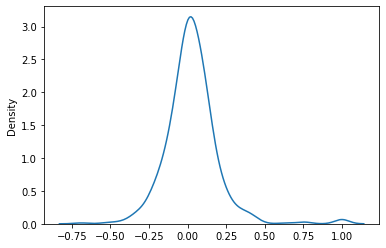

In [39]:
sns.kdeplot(margs)

In [40]:
#sns.kdeplot(original)

In [41]:
#budget = round(disc / 1.5)
#budget


In [42]:
links = list(plausible.edges)

In [43]:
len(links)

5

In [44]:
def random_individual(links):
    
    individual = []
    
    for e in links:
        individual.append(random.randint(0,1))
    

    return individual 

In [45]:
def evaluate(individual, g):
    
    eva = 0
    
    eva_g = copy.deepcopy(g)
    
    individual = individual[0] #<- because DEAP
    
    nodes = set()

    
    index = [i for i, j in enumerate(individual) if j == 1]

    new_links = [links[i] for i in index]

    #print (new_links)
    for l in new_links:
        if l is not None:
            eva_g.add_edge(l[0], l[1])
            
    for node in disc_nodes:
        marg = 0
        egonet = nx.ego_graph(eva_g, node, center=True)
        egonet_attrs = list(nx.get_node_attributes(egonet, 'gender').values())
        #print ("attr:", attr)
        #print ("egonet_attrs:", egonet_attrs)
        try:
            count = dict(Counter(egonet_attrs))[attr]
        except: 
            count = 0
        
        #print ("count:", count)
        size = len(egonet)
        if size > 2:
            marg = ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2
            if abs(marg) > threshold:
                eva = eva+1
            
    return eva, #<- la virgola ci deve stare don't ask vuole tuple sempre e comunque help

In [46]:
#def mutate(individual):
    

    #a differenza di "Evaluate", l'individual della funzione di mutazione è effettivamente l'individuo
    #individual[n] è l'elemento di indice n di individual

   # index = random.randint(0, len(individual)-1)
    #individual[index] = None
    
    #return individual,

In [47]:
creator.create("Fitness", base.Fitness, weights=(-1.0,)) # <- -1 perché vogliamo minimizzare la fitness
creator.create("Individual", list, fitness=creator.Fitness) #<- l'individuo è definito come lista

toolbox = base.Toolbox() #creiamo il toolbox

toolbox.register("random_individual", random_individual, links) 
#"nome_della_funzione per deap", nome_della_funzione vera e propria di python, parametri che passi alla funzione

toolbox.register("individual", tools.initRepeat, creator.Individual, 
                 toolbox.random_individual, n=1) 
# n = numero di individui nella popolazione. Lasciamo 1

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate, g=g) #funzione di valutazione. Vedi quanto detto sopra
toolbox.register("mate", tools.cxTwoPoint) #funzione di crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05) #funzione di mutazione custom
#perché specifichiamo df = df? 
#Non so se è bug o feature, ma se non lo facciamo deap assegna alle nostre variabili (come "df") altri valori...
toolbox.register("select", tools.selTournament, tournsize=3)
#tools.selNSGA2) #funzione di selezione

/Users/federico/miniforge3/envs/tf/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/federico/miniforge3/envs/tf/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [48]:
#def GA():

print ('Marginalized nodes:', disc, '· Available links:', len(links))
NUM_GENERATIONS = 100 #numero di generazioni
POPULATION_SIZE = 100 #popolazione per gen

CXPB, MUTPB = 0.5, 0.25 #crossover e mutation probability

n_HOF = 10 #top soluzioni da ritornare (la "Hall of Fame" di DEAP è il set di tutte le top n soluzioni)

pop = toolbox.population(n=POPULATION_SIZE)

hof = tools.HallOfFame(n_HOF)

stats = tools.Statistics(lambda ind: ind.fitness.values)   
stats.register('min', np.min) #, axis = 0)
stats.register('avg', np.mean) #, axis = 0)

logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + stats.fields

invalid_individuals = [ind for ind in pop if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_individuals)
for ind, fit in zip(invalid_individuals, fitnesses):
    ind.fitness.values = fit

hof.update(pop)
hof_size = len(hof.items)

record = stats.compile(pop)
logbook.record(gen=0, best="-", nevals=len(invalid_individuals), **record)
print(logbook.stream)

for gen in range(1, NUM_GENERATIONS + 1):

            # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))


    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1[0], child2[0])
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant[0])
            del mutant.fitness.values


    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the hall of fame with the generated individuals
    hof.update(offspring)

    # Replace the current population by the offspring
    pop[:] = offspring

    # Append the current generation statistics to the logbook
    record = stats.compile(pop) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    print(logbook.stream)


hof.update(pop) # la HoF è aggiornata con la nuova popolazione (o meglio, i suoi individui migliori w.r.t. fitness)

plt.figure(1)

minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
#plt.plot(maxFitnessValues, color='red')
plt.plot(minFitnessValues, color='blue')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.title('Avg and Min Fitness')
# show both plots:
plt.show()


#return hof.items

Initial disc: 7
Links: 5
gen	nevals	min	avg 
0  	100   	1  	3.35
1  	58    	1  	2.2 
2  	55    	1  	1.48
3  	53    	1  	1.16
4  	62    	1  	1.11
5  	52    	1  	1.05
6  	60    	1  	1.06
7  	50    	1  	1.04
8  	55    	1  	1.08
9  	58    	1  	1.07
10 	59    	1  	1.02
11 	65    	1  	1.06
12 	56    	1  	1.05
13 	67    	1  	1.06
14 	71    	1  	1.05
15 	65    	1  	1.04
16 	68    	1  	1.05
17 	69    	1  	1.09


KeyboardInterrupt: 

In [ ]:
plt.figure(1)

minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
#plt.plot(maxFitnessValues, color='red')
plt.plot(minFitnessValues, color='blue')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.title('Avg and Min Fitness')
# show both plots:
plt.show()


In [ ]:
for e in hof.items:
    print ('Discrimination:', e.fitness.values)
    print (e)
    print ("==")

In [ ]:
hof.items[0].fitness.values

In [ ]:
disc

In [ ]:
rans = []
c = 0
while c < 30:
    ran = random_individual (links)
    print (ran)
    print ("Discrimination", evaluate([ran], g))
    rans.append(evaluate([ran], g)[0])
    c = c+1